We benchmark against adversary with $\epsilon=0.5$,
to match https://github.com/RobustBench/robustbench.

Natural model from https://github.com/MadryLab/robustness

Robust model from https://github.com/deepmind/deepmind-research/tree/master/adversarial_robustness

### Load libraries

In [1]:
import dataclasses
from typing import Dict, List, Optional, Tuple, Union
import warnings

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore", category=matplotlib.MatplotlibDeprecationWarning)

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion import ProjectedGradientDescent

import torch
import torch.nn as nn

import robustbench.utils

[torch.cuda.get_device_name(a)
    for a in range(torch.cuda.device_count())]

['NVIDIA GeForce RTX 3080']

In [3]:
import sys
sys.path.append("../..")

from adversarial_ntks import dataset

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


### Load data

In [4]:
CIFAR_TEST = dataset.get_np_data(
    name="cifar10", split="test",
    agg_labels=((0,1,2,3,4),(5,6,7,8,9)),
    flatten=False,
)
CIFAR_TEST = CIFAR_TEST.replace_xs(
    CIFAR_TEST.xs.astype(np.float32)
)

CIFAR_TEST_CHAN_FIRST = CIFAR_TEST.replace_xs(
    np.moveaxis(CIFAR_TEST.xs, -1, 1)
)

print(CIFAR_TEST.xs.shape, CIFAR_TEST.xs.min(), CIFAR_TEST.xs.max())
print(CIFAR_TEST_CHAN_FIRST.xs.shape)

(10000, 32, 32, 3) 0.0 1.0
(10000, 3, 32, 32)


[1 0 1 1 1 0 1 0 0 0]


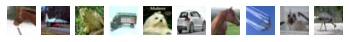

In [5]:
dataset.plot_images(CIFAR_TEST, channels=3, flat=False)

### Load models

In [6]:
class BinModel(nn.Module):
    def __init__(self, model10: nn.Module):
        super().__init__()
        self.model10 = model10
        
    def forward(self, xs):
        out10 = self.model10.forward(xs)
        out2by5 = out10.view(-1, 2, 5)
        out2 = torch.max(out2by5, dim=-1).values
        return out2

In [7]:
base_nat_model = robustbench.utils.load_model(
    model_name="Standard",
    dataset="cifar10",
    threat_model="L2",
)
nat_model = BinModel(base_nat_model)
nat_model.eval();

In [7]:
base_rob_model = robustbench.utils.load_model(
    model_name="Gowal2020Uncovering_extra",
    dataset="cifar10",
    threat_model="L2",
)
rob_model = BinModel(base_rob_model)
rob_model.eval();

### Experiment setup

In [8]:
def run_experiment(
    bin_model: BinModel,
    ds: dataset.Dataset,
    attack_norm: Union[float, int],
    attack_eps: float,
    attack_eps_step: float,
    attack_iters: int,
    batch_size: int,
    seed: int = 42
):
    """
    ART code derived from
    1. https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/notebooks/adversarial_retraining.ipynb
    2. https://github.com/Trusted-AI/adversarial-robustness-toolbox/issues/238
    3. https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/examples/get_started_pytorch.py
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    bin_model.eval()
    
    art_model = PyTorchClassifier(
        model=bin_model,
        input_shape=ds.xs[0].shape,
        nb_classes=ds.num_classes,
        clip_values=(0, 1),
        loss=nn.CrossEntropyLoss(),
    )
    art_pgd_attack = ProjectedGradientDescent(
        art_model,
        norm=attack_norm,
        eps=attack_eps,
        eps_step=attack_eps_step,
        max_iter=attack_iters,
        batch_size=batch_size,
        verbose=True,
    )
    
    preds_nat = art_model.predict(x=ds.xs)
    acc_nat = np.mean(np.argmax(preds_nat, axis=-1) == ds.ys)
    print(f"Nat acc: {acc_nat:.4f}")
    
    xs_pgd = art_pgd_attack.generate(x=ds.xs, y=ds.ys)
    preds_pgd = art_model.predict(x=xs_pgd)
    acc_pgd = np.mean(np.argmax(preds_pgd, axis=-1) == ds.ys)
    print(f"PGD acc: {acc_pgd:.4f}")
    
    return dict(
        acc_nat=acc_nat,
        acc_pgd=acc_pgd,
        xs_pgd=xs_pgd,
        preds_pgd=preds_pgd,
    )

# Run experiments

### Natural model

In [9]:
%%time

NAT_RES_DICT = run_experiment(
    bin_model=nat_model,
    ds=CIFAR_TEST_CHAN_FIRST.prefix(1024),
    attack_norm=2,
    attack_eps=0.5,
    attack_eps_step=0.5/10,
    attack_iters=20,
    batch_size=128,
    seed=42,
)

Nat acc: 0.9629


PGD - Batches:   0%|          | 0/8 [00:00<?, ?it/s]

/home/ttw/.miniconda3/envs/adv-ntk/lib/python3.8/site-packages/art/estimators/classification/pytorch.py:670: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_grad = torch.tensor(x).to(self._device)
/home/ttw/.miniconda3/envs/adv-ntk/lib/python3.8/site-packages/art/estimators/classification/pytorch.py:671: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_grad = torch.tensor(y).to(self._device)


PGD acc: 0.0439
CPU times: user 1min 6s, sys: 1.04 s, total: 1min 7s
Wall time: 1min 16s


Nat data
[1 0 1 1 1 0 1 0 0 0]


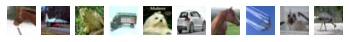

PGD data
[1 0 1 1 1 0 1 0 0 0]


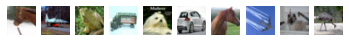

PGD preds
[0 1 0 0 0 1 0 1 1 1]


In [11]:
print("Nat data")
dataset.plot_images(CIFAR_TEST, channels=1, flat=False)

print("PGD data")
dataset.plot_images(
    dataset.Dataset(
        xs=np.moveaxis(NAT_RES_DICT["xs_pgd"], 1, -1),
        ys=CIFAR_TEST.ys[:1024],
        one_hot=False,
        num_classes=2,
    ), channels=1, flat=False
)
print("PGD preds")
print(NAT_RES_DICT["preds_pgd"][:10].argmax(axis=-1))

### Robust model

In [11]:
%%time

ROB_RES_DICT = run_experiment(
    bin_model=rob_model,
    ds=CIFAR_TEST_CHAN_FIRST.prefix(1024),
    attack_norm=2,
    attack_eps=0.5,
    attack_eps_step=0.5/10,
    attack_iters=20,
    batch_size=32,
    seed=42,
)

Nat acc: 0.9609


PGD - Batches:   0%|          | 0/32 [00:00<?, ?it/s]

PGD acc: 0.8516
CPU times: user 5min 48s, sys: 21 s, total: 6min 9s
Wall time: 7min 57s
